In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('blanquart.couples.for.fitting.all.columns.csv')
df = df.set_index('Couple')

In [9]:
df

,male.firstPosDate,male.lastNegDate,female.firstPosDate,female.lastNegDate,male.index,female.index,female.firstObsDate,male.firstObsDate,female.lastObsDate,male.lastObsDate,...,assay,n.vl.ur,spvl.ur,partner.ever.seroconverted,partner.first.pos.after.art,partner.seroconverted.before.art,index.inferred.spvl.start.date,partner.inferred.seroconversion.date,infectious.contact.period.end,duration
Couple,,,,,,,,,,,,,,,,,,,,,
1,2002.1,2000.8,1994.9,NaN,False,True,1994.9,1994.9,2002.1,2002.1,...,Roche 1.0,4,3.085649,True,False,True,1995.4,2001.45,2001.45,6.05
7,inf,1995.7,1994.9,NaN,False,True,1994.9,1994.9,1995.7,1995.7,...,Roche 1.0,1,2.750508,False,False,False,1995.4,inf,1995.70,0.30
9,2002.1,2000.8,inf,2007.9,True,False,2002.1,2002.1,2003.3,2002.1,...,Roche 1.0,1,5.669317,False,False,False,2002.6,inf,2003.30,0.70
11,inf,1996.5,1994.9,NaN,False,True,1994.9,1994.9,1996.5,1996.5,...,Roche 1.0,5,3.595304,False,False,False,1995.4,inf,1996.50,1.10
14,1994.9,NaN,inf,2000.9,True,False,1999.8,1999.8,2000.9,2000.7,...,Roche 1.0,1,3.327359,False,False,False,1995.4,inf,2000.90,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,inf,2008.2,1995.4,NaN,False,True,2004.8,2004.9,2008.2,2008.2,...,Roche 1.5,1,5.745893,False,False,False,1995.9,inf,2005.20,9.30
3114,inf,2009.1,2005.6,NaN,False,True,2005.6,2005.6,2009.1,2009.1,...,Roche 1.5,1,2.966611,False,False,False,2006.1,inf,2007.30,1.20
3117,inf,2013.5,2002.6,NaN,False,True,2006.7,2006.7,2011.6,2011.6,...,Roche 1.5,1,3.723456,False,False,False,2003.1,inf,2005.20,2.10


# Distribution of set point viral load

<Axes: ylabel='Frequency'>

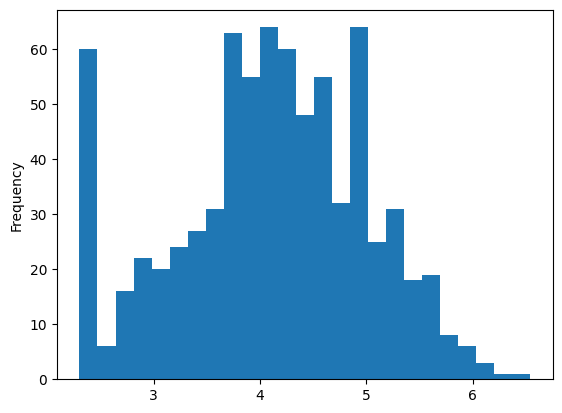

In [10]:
df['spvl'].plot.hist(bins=25, cumulative=False)

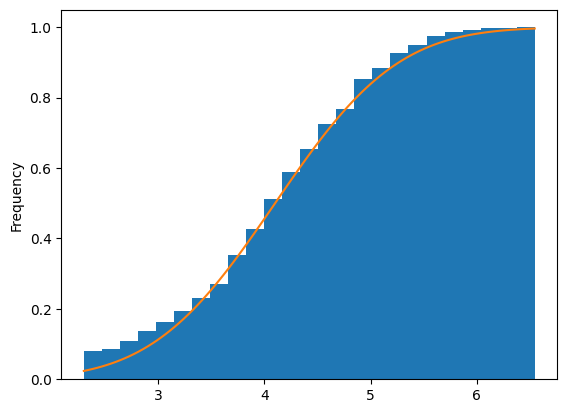

In [11]:
from scipy.stats import kstest, norm

ax = df['spvl'].plot.hist(bins=25, cumulative=True, density=True)
x = np.linspace(df['spvl'].min(), df['spvl'].max(), 100)
ax.plot(x, norm(df['spvl'].mean(), df['spvl'].std()).cdf(x))

In [12]:
kstest(df['spvl'], norm(df['spvl'].mean(), df['spvl'].std()).cdf).pvalue

0.043098851411678796

**Observation:** the data is not normally distributed.

# False negativity analysis

In the RCSS data used by Blanquart et al. the viral load measurement had a detection threshold of 400 copies/mL. Measurements below this threshold were censored. The authors identify a number of reasons that a measurement might be below the detection threshold:

1. The participant is an 'elite controller' who truly has a low viral load at the time of measurement.
2. A measurement error and/or degradation of the RNA sample.
3. The participant was prescribed ART in a clinic other than the RHSP clinics and did not report that fact.
4. The participant is falsely believed to be infected.

In order to account for factor 2, Blanquart et al. "assumed that any single viral load measure below 400 copies/mL in a participant with more than one measure over 400 copies/mL was due to either error or sample degradation, and we removed these measurements from our analysis (44 measures out of 2135)."

If we assume that the event of a measurement error or sample degradation is independent of how many past measurements have been made of the individual and independent of the participant's viral load, then the measurements rejected by above can be seen as establishing a minimum false negative rate of $44/2135 \approx 2.06 \%$.

# Transmission given undetectable viral load

Four couples where the index partner always recorded an undectable viral load (5 measurements total; average = 1.25) had a seroconversion in the recipient partner. In and of itself, this is a notable finding because the metastudy of sexual transmission given low-level viremia by Broyles et al. included RCSS only up through the Gray study (2000) which had 0 transmission events when the index partner had undectable viral load.

In [13]:
df[(df['n.vl.ur'] == 0) & df['partner.seroconverted.before.art']]['n.vl']

Couple
356     1
942     2
1255    1
2504    1
Name: n.vl, dtype: int64

Given a putative false negative rate of $2.06 \%$ (this is likely a lower bound on the false negative rate), we can query the significance of these four observations with the following framework:

1. Null hypothesis: given undetectable (< 400 copies/mL) viral load in the index partner, transmission is impossible.
2. Evaluate the p-value for rejecting the null hypothesis given four transmission events and a false negative rate of $2.06\%$.

To complete (2) in the simplest way, we consider all couples where the recipient partner seroconverted regardless of viral load. Given the distribution of viral load measurements across those index partners, we ask how likely would it be to have four or more index partners record only undetectable viral loads due to independently random measurement failures at a rate of $2.06\%$

Anjalika raises the question: should I include the people who were always undetectable. Are they "part of" the null hypothesis. In my mind, yes they are because the null hypothesis is "we would never observe an always-undetectable index partner transmitting unless there was a false negative" -- so it includes the possibility of someone with all false negative measurements.


In [14]:
n_measurements = df[df['partner.seroconverted.before.art']]['n.vl']

In [15]:
from scipy.stats import binom

p_false_negative = 0.0206
n_undectables = []
for i in range(20000):
    n_failure_samples = binom(n_measurements, p_false_negative).rvs()
    n_undetectable = np.sum(n_failure_samples == n_measurements)
    n_undectables.append(n_undetectable)
n_undectables = np.array(n_undectables)

In [16]:
np.quantile(n_undectables, 0.95)

3.0

In [17]:
print("P value for rejecting null hypothesis:", np.sum(n_undectables >= 4) / np.shape(n_undectables) * 100)

P value for rejecting null hypothesis: [1.68]


**Observation:** with a false negative rate of 2.06%, we can reject the null hypothesis that transmission is impossible for index patients who only record undetectable results. (This assumes the only mode of measurement inaccuracy is complete failure. It does not include noise in the measurement.)

**Note:** we also aren't including the possibility for extra-partner transmission. (Recall: these cases aren't confirmed to be linked.)

# False negative rates and normality of the distribution

We resample the distribution by assuming X% of the undetectable measurements were false negatives. We handle this process in two ways

1. Remove the undetectable measurement and recalculate VL as if the measurement didn't exist.
2. After removing all those measurements, calculate the mean and variance of SPVL and then draw random values from the normal with that mean and variance and reassign them to the presumptive false negatives.

In each case, we then compare the resultant distribution to a normal distribution using the KS test.

**Note:** neither of these approaches corrects for the fact that instead of doing something sensible for the censored data, we supply 200 copies / mL for all of the ones that *aren't* false negative in both cases.

In [18]:
def resample(df, p_false_negative):
    df = df.copy()
    # for negative tests, assume that p fraction was false negative
    # ie the true viral load was > 400 copies/mL
    n_now_positive = binom(df['n.vl'] - df['n.vl.ur'], p_false_negative).rvs()

    # since it's unclear what VL to supply as the true VL in these observations,
    # we try two approaches
    # (1) hide those measurements
    df['spvl2'] = (df['spvl'] * df['n.vl'] - n_now_positive * np.log10(200)) / (df['n.vl'] - n_now_positive)
    df_hidden = df[(df['n.vl'] - n_now_positive) > 0]
    df['spvl2'] = np.where(
        (df['n.vl'] - n_now_positive) == 0,
        0,
        df['spvl2']
    )

    # (2) after hiding those measurements, calculate the mean and variance of distribution
    # and then replace those measurements with RVs from the normal distribution with that mean and variance
    mean, std = df['spvl2'].mean(), df['spvl2'].std()
    n = norm(mean, std)
    replacement_vls = n.rvs(np.sum(n_now_positive))
    added_vl = []
    i = 0
    for n in n_now_positive:
        added_vl.append(np.sum(replacement_vls[i:i+n]))
        i += n
    df['spvl3'] = (df['spvl2'] * (df['n.vl'] - n_now_positive) + added_vl) / (df['n.vl'])

    return df_hidden['spvl2'], df['spvl3']

In [19]:
p_false_negative = 0.10

spvl_hidden, spvl_resampled = resample(df, p_false_negative)

In [20]:
pd.isna(spvl_resampled).any()

False

## Hide false negatives

0.06824954314172416

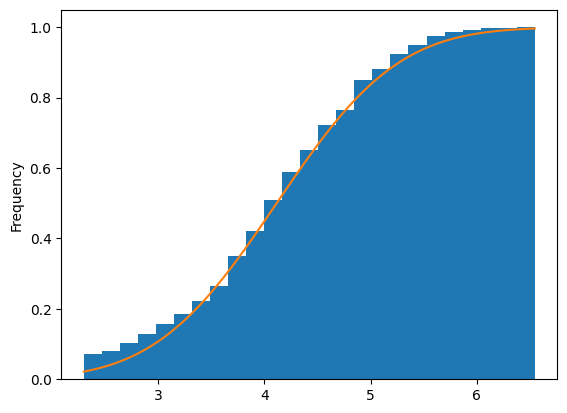

In [21]:
ax = spvl_hidden.plot.hist(bins=25, cumulative=True, density=True)
x = np.linspace(spvl_hidden.min(), spvl_hidden.max(), 100)
ax.plot(x, norm(spvl_hidden.mean(), spvl_hidden.std()).cdf(x))

kstest(spvl_hidden, norm(spvl_hidden.mean(), spvl_hidden.std()).cdf).pvalue

## Replace false negatives

In [22]:
spvl_hidden.mean(), spvl_hidden.std()

(4.115324803826128, 0.8991230213180711)

0.13139875478772467

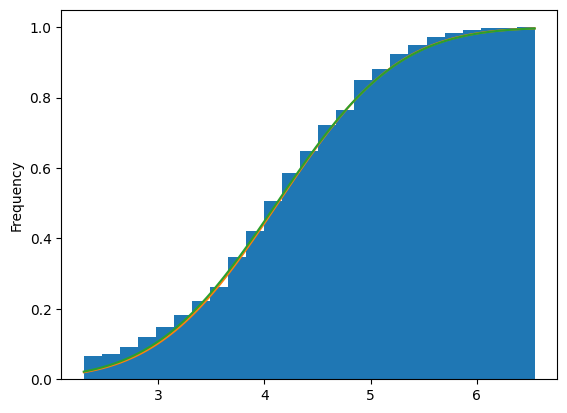

In [23]:
ax = spvl_resampled.plot.hist(bins=25, cumulative=True, density=True)
x = np.linspace(spvl_resampled.min(), spvl_resampled.max(), 100)
ax.plot(x, norm(spvl_resampled.mean(), spvl_resampled.std()).cdf(x))
ax.plot(x, norm(spvl_hidden.mean(), spvl_hidden.std()).cdf(x))

kstest(spvl_resampled, norm(spvl_resampled.mean(), spvl_resampled.std()).cdf).pvalue

**Observation:** as obviously is expected, when we replace the "false negative" values with the samples from the normal distribution with mean + variance determiend by non-false-negative-values, we get a distribution that is closer to normal.

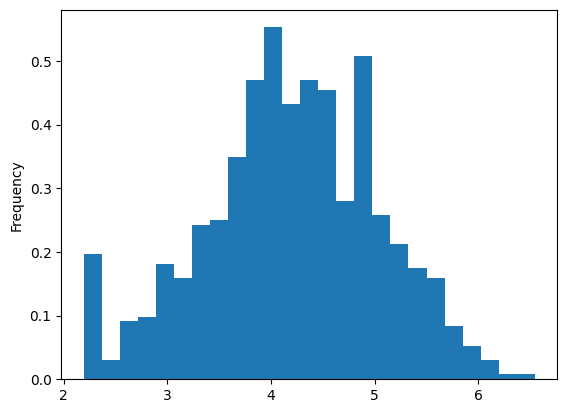

In [24]:
_, spvl_resampled = resample(df, 0.35)
ax = spvl_resampled.plot.hist(bins=25, density=True)

**Observation:** even with a large false negative rate (35% above), the data still apppears enriched at small values relative to a normal.

# Model part 1: population model and observation model towards redistributing censored data

- Problem: the viral load measurements are censored if their value is below 400 copies / mL.
- Problem: and some values are censored randomly due to false negatives.
- Desire: redistribute the censored viral load measurements (taking into account the possibility of false negatives) below 400 copies / mL
- Approach: propose a model for the viral load distribution in the population and a model for the observation process. Find the parameters for the population viral load model and observation model that maximize the likelihood of observing our data. Then redistribute censored data in accordance with the population model defined at the MLE.

## Population model:

- Two classes of individuals: elite controllers and ordinary individuals. Fraction $q$ of individuals are elite, fraction $1-q$ are not.
- Viral load among elite controllers: $\text{Normal} (\mu_{\text{e}}, \sigma^2_\text{e})$. PDF: $f_\text{elite}$.
- Viral load among non-elite controllers $\text{Normal} (\mu_{\text{o}}, \sigma^2_\text{o})$. PDF: $f_\text{ordinary}$.
- PDF of viral load in the population:

Monkey paper said <400 copies/mL is most common def for elite control in humans

$$ f_\text{pop} (\text{VL}_\text{true}) =  q f_\text{elite} (\text{VL}_\text{true}) + (1 - q) f_\text{ordinary} (\text{VL}_\text{true}).$$

## Viral load observation model:

- Assume that every individual has a fixed $\text{VL}_\text{true} = \text{SPVL}_\text{true}$ (ie there's no variability in someone's viral load, so all variability in the measurement is due to noise)
- Measurements have (on log 10 scale) Gaussian noise $\text{Normal}(0, \sigma_\text{noise}^2)$.
- Any measurement of a value below $\text{LLD} = 400$ copies / mL (after noise) is censored.
- Additionally and *independently*, there is a constant probability that a viral load measurement will appear censored due to a false negative: $p_\text{false negative}$.
- The number of measurements made of an individual are independent of any feature of that individual. **Is this true? Is there some weird entanglement where once your partner seroconverts you get dropped from the data so maybe we have more observations for people with low viral loads?** 

This lumps together all variation as noise. Do we need to think about "natural variation" vs noise? 

## Viral load observation content:

For each individual $i$, we make the following observation:

$$\mathcal{O}_i = \{ n_i, k_i, \text{SPVL}_i^o \}$$

- $n_i$: number of times viral load is measured.
- $k_i$: number of times an undetectable result is recorded. $k_i \le n_i$.
- $\text{SPVL}^o_i$: the observed ($=^o$) average (in log space) of **uncensored** viral load observations.

## Likelihood of observation given the two models

Let the collection of all model parameters be called $\theta$

$$ \theta = \theta_\text{pop} \cup \theta_\text{obs} = \{ q, \mu_e, \sigma_e, \mu_o, \sigma_o \} \cup \{ p_\text{false negative}, \sigma_\text{noise} \}$$

By assumption, individual $i$ has a fixed $\text{VL}_\text{true} = \text{SPVL}_\text{true}$. By the law of total probability, the likelihood of observing $\mathcal{O}_i$ given the model is:

$$ \mathcal{L} (\mathcal{O}_i | \theta ) = \int_{\text{VL}_\text{true} = 0}^\infty f_\text{pop} (\text{VL}_\text{true}; \theta_\text{pop}) P(\mathcal{O}_i | \text{VL}_\text{true}; \theta_\text{obs}) d\text{VL}_\text{true}$$

The first term in the integral is known:

$$ f_\text{pop} (\text{VL}_\text{true}; \theta_\text{pop}) =  q f_\text{elite} (\text{VL}_\text{true}; \theta_\text{pop}) + (1 - q) f_\text{ordinary} (\text{VL}_\text{true}; \theta_\text{pop}).$$

The second term in the integral is more complicated to evaluate.

### The probability of an observation given a known fixed viral load

The probability of $\mathcal{O}_i$ given the model and the viral load may be split apart into a probability for observing $k_i$ undetectable results in $n_i$ tries and a probability for observing the given mean among the $n-k$ other measurements:

$$ P(\mathcal{O}_i | \text{VL}_\text{true}; \theta_\text{obs}) = P((n_i,k_i) | \text{VL}_\text{true}; \theta_\text{obs}) P( (\text{SPVL}_i^o, n - k) | \text{VL}_\text{true}; \theta_\text{obs}) $$

For a given true viral load, the observations of (the log 10 of) that viral load would follow the normal distribution $\text{Normal} (\text{VL}_\text{true}, \sigma_\text{noise}^2)$ if not for censoring and false negatives. Let $F_\text{uncensored}$ be the CDF of this normal distribution without censoring.

Then for the first term in the previous equation we have:

$$ P((n_i,k_i) | \text{VL}_\text{true}; \theta_\text{obs}) = \text{Binom}(n_i, P(\text{undetectable} | \text{VL}_\text{true}; \theta_\text{obs})) (k_i) $$

where the probability of an undetectable result is the probability that either we have a false negative or would-be measurement below 400 copies / mL. Given independence:

$$P(\text{undetectable} | \text{VL}_\text{true}; \theta_\text{obs}) = 1 - (1 - p_\text{false negative}) (1 - F_\text{uncensored}(\log_{10} (\text{LLD})))$$

That resolves one term. For the second term, we need to know the probability that we observe an average value of $\text{SPVL}^o_i$ across $n-k$ measurements, which weren't censored, given a true viral load $\text{VL}_\text{true}$ and a model $\theta_\text{obs}$. The outcome of one observation of a viral load given that it was not censored is a random variable, call it $X$, distributed as a half-truncated normal distribution. The probability in question is 

$$ P( (\text{SPVL}_i^o, n - k) | \text{VL}_\text{true}; \theta_\text{obs}) = f_{\frac{X + X + \ldots + X}{n -k}} (\text{SPVL}^o_i)\\
X \sim \text{TruncatedNormal}(\text{SPVL}^o_i, \sigma_\text{noise}, x \in [\log_{10} (\text{LLD}), \infty))$$

ie the probability that the value of $n - k$ convolutions of $X$ produces $(n - k) \cdot \text{SPVL}^o_i$. To my knowledge this probability cannot be evaluated analytically, so we will numerically compute it.

So in all:

$$ \mathcal{L} (\mathcal{O}_i | \theta ) = \int_{\text{VL}_\text{true} = 0}^\infty f_\text{pop} (\text{VL}_\text{true}; \theta_\text{pop}) f_{\frac{X + X + \ldots + X}{n -k}} (\text{SPVL}^o_i) \text{Binom}(n_i, P(\text{undetectable} | \text{VL}_\text{true}; \theta_\text{obs})) (k_i) d\text{VL}_\text{true}\\
P(\text{undetectable} | \text{VL}_\text{true}; \theta_\text{obs}) = 1 - (1 - p_\text{false negative}) (1 - F_\text{uncensored}(\log_{10}(\text{LLD})))$$

If we fit all at once, we're inherently enforcing the truth of our transmission model more than otherwise. If we fit separately transmission from this part, we have a different philosophy of relationship of transmission observation.

STAN MCMC https://pystan.readthedocs.io/en/latest/

Alison's friend who has an MCMC wrapper used in astrophysics. EMCEE https://emcee.readthedocs.io/en/stable/ https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

Good starting values always helps

In [247]:
from dataclasses import dataclass
import scipy.integrate
from scipy.stats import truncnorm
from scipy.signal import convolve

@dataclass()
class ThetaObs():
    p_false_negative: float
    sigma_noise: float

@dataclass()
class ThetaPop():
    q: float
    mu_e: float
    sigma_e: float
    mu_o: float
    sigma_o: float

    def __post_init__(self):
        self.pdf_e = norm(self.mu_e, self.sigma_e).pdf
        self.pdf_o = norm(self.mu_o, self.sigma_o).pdf

def build_convolution(spvl, sigma_noise, lld, n_detectable, delta=1e-4):
    if n_detectable == 0:
        return lambda x: 1
    # why not just LLD? see scipy documentation notes about truncation being based on std
    t = truncnorm((lld - spvl)/sigma_noise, np.inf, loc=spvl, scale=sigma_noise)
    if n_detectable == 1:
        return t.pdf
    # go 10 stds above mean to capture all probability
    grid = np.arange(0, spvl * n_detectable + 10 * sigma_noise * n_detectable, delta)

    # discretize the pdf of the truncated normal on this grid as a pmf
    pmf = t.pdf(grid) * delta
    #print("HERE:", np.trapz(pmf, grid))
    c = pmf.copy()
    # n-1 because we start with our first convolution which happens when we have 2 observations
    for i in range(n_detectable-1):
        c = convolve(c, pmf, 'full')[0:len(grid)]
        #print(np.trapz(c / delta, grid), max(c/delta), n_detectable)

    # / delta to convert pmf back to --> pdf
    c_pdf = c / delta

    # only need to calculate convolution once per spvl, sigma_noise, lld, n_detectable
    # and then can query x in constant time as a lookup
    def query_convolution(x):
        # converting from average to sum for the x=VL_true that we query:
        x = x*n_detectable
        # if we are above the top of the grid, we'll say the probability is 0
        # (the integrator may look up here, but the probability is truly infinitessimal)
        if x > grid[-1]:
            return 0
        
        # interpolate the value of x on the grid
        # * n_detectable due to the change of variables x => n*x
        return np.interp(x, grid, c_pdf) * n_detectable
    return query_convolution

LLD = np.log10(400)
# some day we can worry about vectorizing this, for now let's focus on step 1
def get_integrand(n_i, k_i, spvl_i, theta_obs, theta_pop):
    f_pop = lambda x: theta_pop.q * theta_pop.pdf_e(x) + (1 - theta_pop.q) * theta_pop.pdf_o(x)
    F_uncensored = lambda x: norm(x, theta_obs.sigma_noise).cdf(LLD)
    p_undectable = lambda x: 1 - (1 - theta_obs.p_false_negative) * (1 - F_uncensored(x))
    f_binom = lambda x: binom(n_i, p_undectable(x)).pmf(k_i)
    f_conv = build_convolution(spvl_i, theta_obs.sigma_noise, LLD, n_i - k_i)
    def integrand(x):
        return f_conv(x) * f_binom(x) * f_pop(x)
    def verbose_integrand(x):
        f_c = f_conv(x)
        f_b = f_binom(x)
        f_p = f_pop(x)
        return f_c * f_b * f_p, f_c, f_b, f_p
    return integrand, verbose_integrand

def logl_i(n_i, k_i, spvl_i, theta_obs, theta_pop):
    integrand, _ = get_integrand(n_i, k_i, spvl_i, theta_obs, theta_pop)
    return np.log(scipy.integrate.quad(integrand, 0.0, np.inf)[0])


def get_vectorized_integrand(n, k, spvl, theta_obs, theta_pop, verbose=False):
    # yup vectorized
    f_pop = lambda x: theta_pop.q * theta_pop.pdf_e(x) + (1 - theta_pop.q) * theta_pop.pdf_o(x)
    # yup vectorized
    F_uncensored = lambda x: norm(x, theta_obs.sigma_noise).cdf(LLD)
    # yup vectorized
    p_undectable = lambda x: 1 - (1 - theta_obs.p_false_negative) * (1 - F_uncensored(x))
    # yup vectorized
    f_binom = lambda x: binom(n, p_undectable(x)).pmf(k)
    # yup vectorized
    f_conv = build_vectorized_convolution(spvl, theta_obs.sigma_noise, LLD, n - k, grid_points=100)
    def integrand(x):
        return f_conv(x) * f_binom(x) * f_pop(x)
    if not verbose:
        return integrand
    def verbose_integrand(x):
        f_c = f_conv(x)
        f_b = f_binom(x)
        f_p = f_pop(x)
        return f_c * f_b * f_p, f_c, f_b, f_p
    return verbose_integrand

def logl(n, k, spvl, theta_obs, theta_pop, dx=1e-4):
    if isinstance(n, pd.Series):
        n = n.to_numpy()
    if isinstance(k, pd.Series):
        k = k.to_numpy()
    if isinstance(spvl, pd.Series):
        spvl = spvl.to_numpy()
    integrand = get_vectorized_integrand(n, k, spvl, theta_obs, theta_pop)

    upper = 2 * spvl[~pd.isna(spvl)].max()
    print(upper)
    samples = integrand(np.arange(0, upper, dx))
    print(samples.shape)
    return samples

In [248]:
#logl_i(row['n.vl'], row['n.vl'] - row['n.vl.ur'], row['spvl.ur'], theta_obs, theta_pop)
logl(df['n.vl'], df['n.vl'] - df['n.vl.ur'], df['spvl.ur'], theta_obs, theta_pop)

13.088347006


ValueError: operands could not be broadcast together with shapes (130884,) (759,) 

In [30]:
df['spvl'].to_numpy().shape

(759,)

In [31]:
np.array([1,2,3]).shape

(3,)

In [56]:
grid = np.linspace(0, spvl * n_detectable + 10 * sigma_noise * n_detectable, grid_points)
delta = grid[1,:] - grid[0,:]

grid.shape


(20000, 2)

In [210]:
def build_vectorized_convolution(spvl, sigma_noise, lld, n_detectable, grid_points=20000):
    # why not just LLD? see scipy documentation notes about truncation being based on std
    t = truncnorm((lld - spvl)/sigma_noise, np.inf, loc=spvl, scale=sigma_noise)

    # go 10 stds above mean to capture all probability
    grid = np.linspace(0, spvl * n_detectable + 10 * sigma_noise * n_detectable, grid_points)
    # the spacing on each grid (necessary for getting pmf values)
    delta = grid[1,:] - grid[0,:]

    # discretize the pdf of the truncated normal on this grid as a pmf
    pmf = t.pdf(grid) * delta
    #print("HERE:", np.trapz(pmf, grid))
    c = pmf.copy()
    for i in range(grid.shape[1]):
        # n-1 because we start with our first convolution which happens when we have 2 observations
        for n in range(n_detectable[i] - 1):
            c[:,i] = convolve(c[:,i], pmf[:,i], 'full')[0:len(grid)]
            #print(np.trapz(c / delta, grid), max(c/delta), n_detectable)

    # / delta to convert pmf back to --> pdf
    c_pdf = c / delta

    # only need to calculate convolution once per spvl, sigma_noise, lld, n_detectable
    # and then can query x in constant time as a lookup
    def query_convolution(x):
        assert(np.all(x >= 0))
        # converting from average to sum for the x=VL_true that we query:
        x = x*n_detectable

        idx_floor = np.floor(x / delta).astype('int')
        idx_ceil  = np.ceil(x / delta).astype('int')
        idx_individuals = np.arange(0,len(idx_floor))
        # if we are above the top of the grid, we'll say the probability is 0
        # (the integrator may look up here, but the probability is ~0 
        # as long as we set a large enough max in each of our grids)
        in_grid_mask = x < grid[-1, :]

        idx_floor[~in_grid_mask] = 0
        idx_ceil[~in_grid_mask] = 0

        slope = np.where(
            in_grid_mask,
            (c_pdf[idx_ceil, idx_individuals] - c_pdf[idx_floor, idx_individuals])/delta,
            0
        )
        
        # interpolate the value of x on the grid
        val = np.where(
            in_grid_mask,
            c_pdf[idx_floor, idx_individuals] + slope * (x - grid[idx_floor, idx_individuals]),
            0,
        )

        # * n_detectable due to the change of variables x => n*x
        return val * n_detectable
    return query_convolution

### Justifying `c = convolve(c, pmf, 'full')[0:len(grid)]`

Suppose `x = [0, 1, 2, 3, 4]` and consider `x * x`. The 0th entry in the full convoluted array is:

```
    (x * x) [0] =              
                    [0, 1, 2, 3, 4]
         *  *  *  *  *
        [4, 3, 2, 1, 0]
```

The convolution of two probability mass functions is:

$$ P(Z = z) = \sum_{k=-\infty}^\infty P(X = k) P(Y= z-k) $$

We can see that the indices of the multiplied entries in the convoluted array is a constant value $-4 + 4 = -3 + 3 = ... = 0+0 = 0$. (Note that the negative indices into the array are padded with a value of 0). So the sum of those indices has the role of $z$ in the convolution of pmfs. Our pmf evaluations began at $x = 0$, so the 0th entry of the full convoluted array is $\text{pmf}_\text{convolution} (z = 0)$. Each time we slide the window, the sum of the indices increases by 1, and therefore the $z$ value that we are querying increases by 1.

```
    (x * x) [1] =              
                    [0, 1, 2, 3, 4]
            *  *  *  *  *
           [4, 3, 2, 1, 0]
```

In the `full` mode, the convolution of one array with itself has `2n - 1` elements. If the $x$ positions of the elements in that array are defined by the constantly spaced sequence $x_1, x_2, \ldots, x_n$ then the $x$ values in the full convolution are $x_1, x_2, \ldots,  x_n, x_n + x_1, x_n + x_2, \ldots, x_n + x_{n - 1}$. $n-1$ in the last entry because there still must be one element that overlaps between the reversed array and the stationary array. Therefore, after we calculate the convolution of $P(x=x), x \in [0, x_\text{max, grid})$ with itself, the first `[0:len(grid)]` values (the first `n` elements) of the convoluted array contain the $x$ values that are on the initial grid.

### Testing our likelihood

In [214]:
theta_obs = ThetaObs(0.0206, 0.25)
theta_pop = ThetaPop(0.07, np.log10(50), 0.1, 4.1, 0.9036287353551126)

In [ ]:
row = df.iloc[0]
row['n.vl'], row['n.vl'] - row['n.vl.ur'], row['spvl.ur']

(5, 1, 3.085649001)

In [ ]:
z = build_convolution(row['spvl.ur'], theta_obs.sigma_noise, LLD, 4)
print(z)
x = np.linspace(0.0, 6.0, 10000)

<function build_convolution.<locals>.query_convolution at 0x2eb13a710>


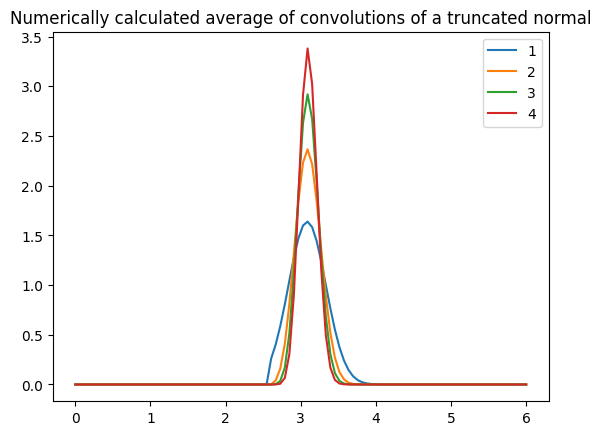

In [ ]:
import matplotlib.pyplot as plt

z1 = build_convolution(row['spvl.ur'], theta_obs.sigma_noise, LLD, 1)
z2 = build_convolution(row['spvl.ur'], theta_obs.sigma_noise, LLD, 2)
z3 = build_convolution(row['spvl.ur'], theta_obs.sigma_noise, LLD, 3)
z4 = build_convolution(row['spvl.ur'], theta_obs.sigma_noise, LLD, 4)


plt.plot(x, [z1(a) for a in x])
plt.plot(x, [z2(a) for a in x])
plt.plot(x, [z3(a) for a in x])
plt.plot(x, [z4(a) for a in x])

plt.title("Numerically calculated average of convolutions of a truncated normal")
plt.legend([1,2,3,4])

In [ ]:
_, f = get_integrand(row['n.vl'], row['n.vl'] - row['n.vl.ur'], row['spvl.ur'], theta_obs, theta_pop)

x = np.linspace(0, 6.0, 100)
y = [f(x) for x in x]

In [ ]:
integrand, f_c, f_b, f_p = zip(*y)

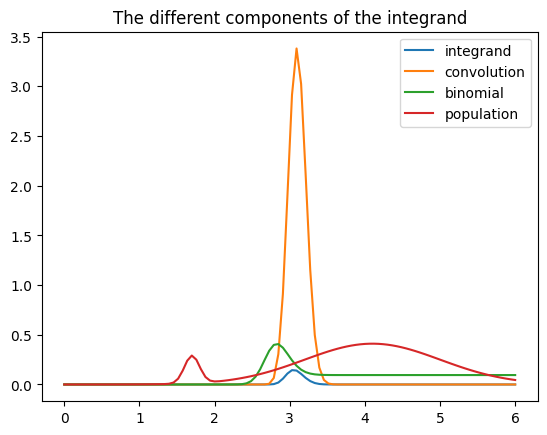

In [ ]:
plt.plot(x, y)

plt.title("The different components of the integrand")
plt.legend(['integrand', 'convolution', 'binomial', 'population'])

In [ ]:
# when integrating between 2 and 3 get roundoff error, seems to maybe be the culprit for evaluating the full integral?
# same deal between 3 and 4
# but <2 and >4 no problems

# maybe numerical trouble is because the convolution pdf is only evaluated on a particular scale, the integrator is having trouble as it tries to traverse x values at a very fine scale because the pdf is discretized
logl_i(row['n.vl'], row['n.vl'] - row['n.vl.ur'], row['spvl.ur'], theta_obs, theta_pop)

4


-3.153223706441296

In [ ]:
logl = []
for i,row in df.iterrows():
    logl.append(logl_i(row['n.vl'], row['n.vl'] - row['n.vl.ur'], row['spvl.ur'], theta_obs, theta_pop))

df['logl'] = logl

In [ ]:
np.sum(df['logl'])

-2232.4932279827863

### How to numerically evaluate $m$ convolutions of a truncated normal [messy -- corrected version has already been incorporated above. will update]

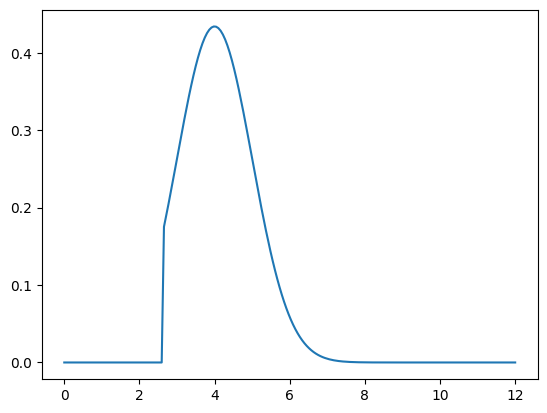

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# Note from the scipy documentation, the a and b parameters to truncnorm
# are not the x coordinates of truncation, but the left and right STDs of truncation
# if we want to truncate at x_left = a_trunc and x_right = b_trunc then this formula converts:
# a, b = (a_trunc - loc) / scale, (b_trunc - loc) / scale
# where loc = mean and scale = std
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

x = np.linspace(0.0, 12, 200)
mean = 4.0
std = 1.0
t = truncnorm((np.log10(400) - mean)/std, np.inf, loc=mean, scale=std)

plt.plot(x, t.pdf(x))

In [ ]:
from scipy.signal import convolve

def f_convolution(x, spvl, sigma_noise, lld, n_detectable, delta=1e-4):
    if n_detectable == 0:
        return 1
    
    # why not just LLD? see scipy documentation notes about truncation being based on std
    t = truncnorm((lld - spvl)/std, np.inf, loc=spvl, scale=sigma_noise)

    if n_detectable == 1:
        return t.pdf(x)
    
    # go 10 stds above mean to capture all probability
    grid = np.arange(0, spvl + 10 * sigma_noise * n_detectable, delta)
    # discretize the pdf of the truncated normal on this grid as a pmf
    pmf = t.pdf(grid) * delta
    print(np.trapz(pmf, grid))
    c = pmf.copy()
    # n-1 because we start with our first convolution which happens when we have 2 observations
    for i in range(n_detectable-1):
        c = convolve(c, pmf, 'full')[0:len(grid)]

    print(np.trapz(c / delta, grid))
    # the nearest value to x calculated in our big grid
    index_of_x = int(np.round(x / delta))
    return c[index_of_x] / delta, c / delta, pmf / delta, grid

In [ ]:
p, c_pmf, original_pmf, grid = f_convolution(np.log10(500)*3, np.log10(500), 0.5, np.log10(400), 6)

0.0 46.1938


TypeError: cannot unpack non-iterable int object

In [ ]:
p

0.03405438402051446

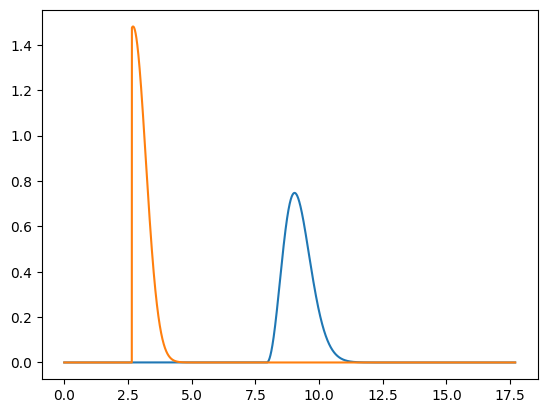

In [ ]:
plt.plot(grid, c_pmf)
plt.plot(grid, original_pmf)

$$ P(Z = z) = \sum_{k=-\infty}^\infty P(X = k) P(Y= z-k)

In [ ]:
c[int(np.round(2/delta))]

8.913267608338033e-05

In [ ]:
x = [0,1,2,3]
#   [3,2,1,0]

# there are 4 + 3 places to put the endpoint of the reversed array
np.convolve(x,x)

array([ 0,  0,  1,  4, 10, 12,  9])

In [ ]:
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
A = [0,0,0,1,2,3,4,5,6,7 ,8 ,9,10,11,12] # [0,0,0,1,2] 
np.convolve(A, A, mode='full')

# the sum of the indices is constant at each slot in the convolution and gives z
# so the 0th entry of the full convolution is z=0
# the 1st entry of the full convolution is z=1
# the last entry of the full convolution is z = 2*n - 1

array([  0,   0,   0,   0,   0,   0,   1,   4,  10,  20,  35,  56,  84,
       120, 165, 220, 286, 364, 429, 480, 516, 536, 539, 524, 490, 436,
       361, 264, 144])

In [ ]:
# our question is what x values correspond to the values of the convolved arrays

In [ ]:
np.convolve(A, A, mode='same')

array([  4,  10,  20,  35,  56,  84, 120, 165, 220, 286, 364, 429, 480,
       516, 536])